### Phys 629: Statistical Tools for Physics Research
***Anuradha Gupta***

# Homework 7
### Due: Friday, Oct 20 at 11:59 pm CT

## Problem 1

This week's problem is worth 40 points. This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw7_data.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

In [49]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import display, Latex

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from scipy import integrate
import pandas as pd 

In [50]:
data = np.load('../../homeworks/hw_data/hw7_data.npy')
df = pd.DataFrame(data, columns = ['x', 'unc'])

# df_s = df.sort_values(by=['x'], axis=0)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_s)

In [51]:
x = data[:,0] #Measurements
unc = data[:,1] #Uncertainties

Sample mean = 4.942118214425304, Standard error on mean = 0.43024334605205083


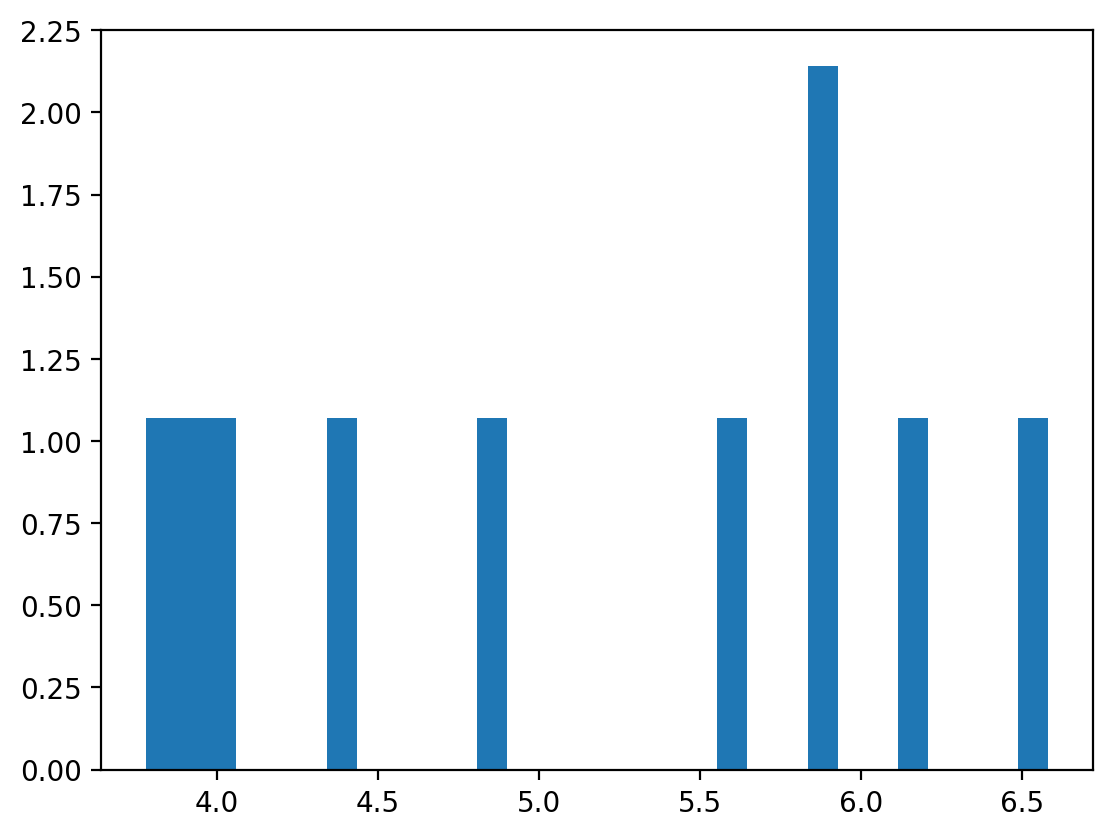

In [52]:
#1
#Sample mean, xbar and std dev, S

N = data.shape[0]

def hetero_mean(x, sigma):
    num = sum(x/sigma**2)
    den = sum(1/sigma**2)
    
    return num/den

def hetero_std(sigma):
    return (sum(1/sigma**2))**(-1/2)



xbar = hetero_mean(x, unc)
sigma_xbar = hetero_std(unc)

print(f'Sample mean = {xbar}, Standard error on mean = {sigma_xbar}')

px, bins, _ = plt.hist(x, 30, density=True);

Optimization terminated successfully.
         Current function value: 16.048013
         Iterations: 16
         Function evaluations: 32
best-fit mean voltage is = 4.942 V


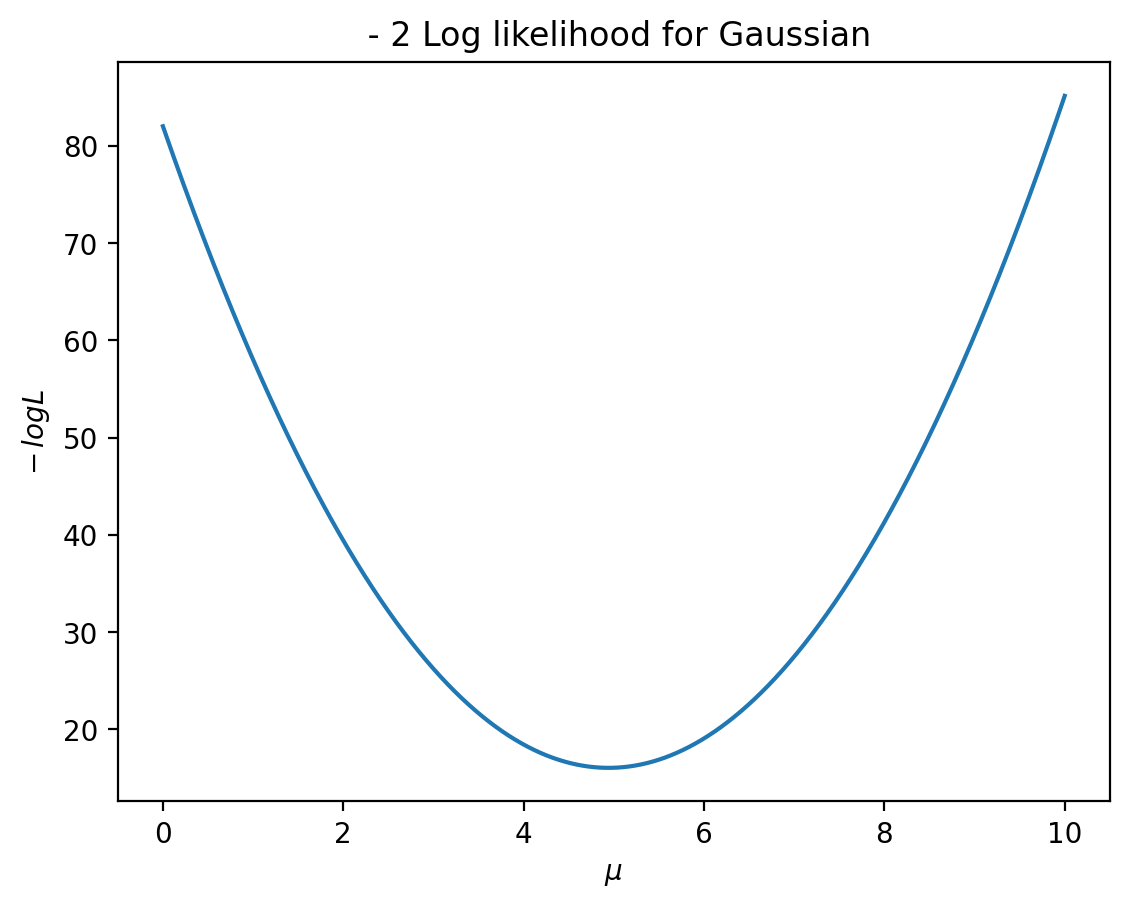

In [53]:
#2

def lnL_G(mu):

    if type(mu) == 'int'  or type(mu) == 'float':
        res = 0
    else:
        res = np.zeros_like(mu)
        
    for i in range(N):
        #L = L * norm.pdf(x[i], loc=mu, scale=unc[i])
        res = res - 0.5 * ((x[i] - mu)/unc[i])**2 + np.log(1/np.sqrt(2*np.pi*unc[i]**2))
    
    return res


def neg_lnL_G(mu):
    return - lnL_G(mu)

mu_prop = np.linspace(0, 10, 10000)

mu2 = optimize.fmin(neg_lnL_G, 6)[0]
print(f'best-fit mean voltage is = {round(mu2,3)} V')

plt.plot(mu_prop, neg_lnL_G(mu_prop))
plt.xlabel('$\mu$')
plt.ylabel('$-\, log L$')
plt.title(' - 2 Log likelihood for Gaussian');


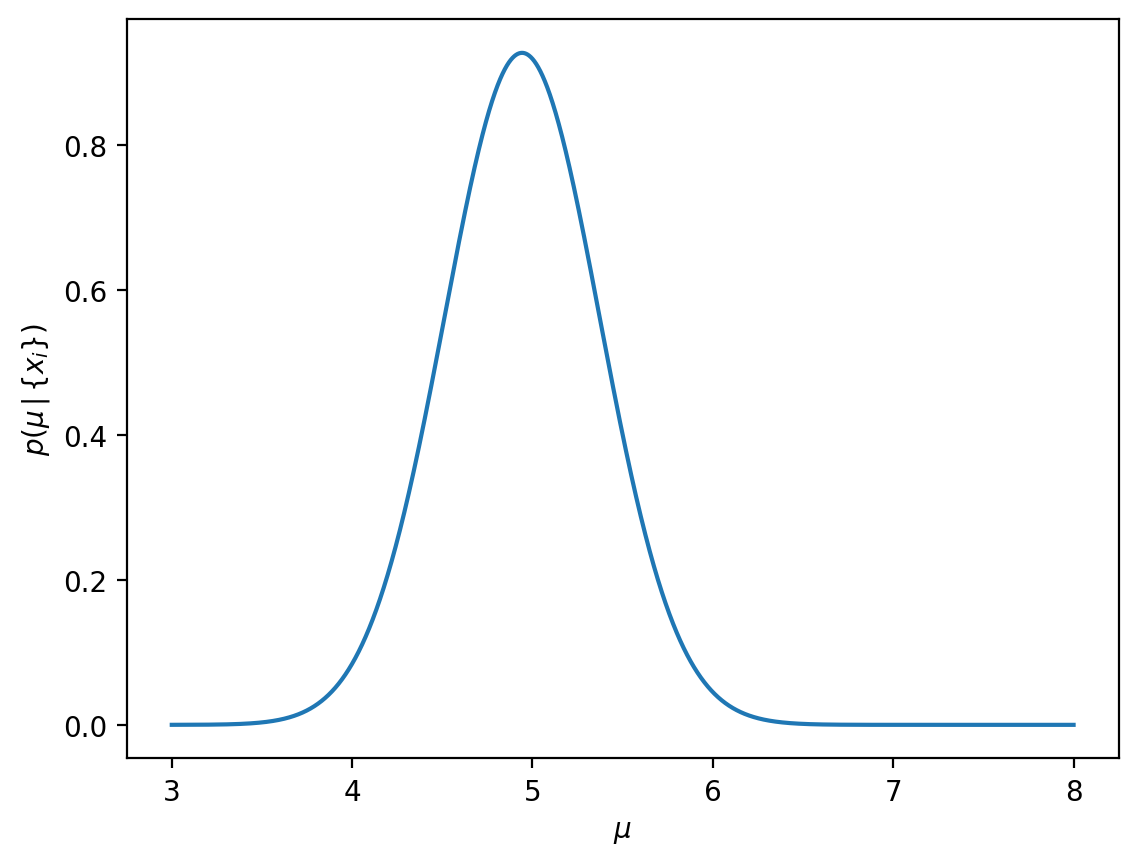

In [54]:
#3 
#Bayesian posterior 

#Posterior = likelihood * prior

#Prior
def prior(mu, upp, low):
    # upp = 7
    # low = 3
    W = upp - low
    return 1/W

#Likelihood
def L(mu):
    #res = np.ones_like(mu)
    # for i in range(N):
    #     res = res * 1/( np.sqrt(2*np.pi * unc[i]**2)) * np.exp( ((x[i] - mu)/unc[i])**2 / 2) 

    # for j in range(mu.size):
    #     for i in range(N):
    #         res[j] = res[j] * ( 1/( np.sqrt(2*np.pi * unc[i]**2)) * np.exp( ((x[i] - mu[j])/unc[i])**2 / 2) )
        
    return np.exp(lnL_G(mu))

#Norm Posterior
def unpost(mu, upp, low):
    return L(mu) * prior(mu, upp, low)
    
def npost(mu, upp, low):
        
    #xgrid = np.linspace(-10**1, 10**1, 10**4)
    nfac = integrate.quad(unpost, -np.inf, np.inf, args = (upp, low))[0]

    npos = unpost(mu, upp, low)/nfac
    #print('evidence = ', nfac)
    return npos

mu_prop = np.linspace(3,8, 10**4)
pos1 = npost(mu_prop, 7, 3)

plt.plot(mu_prop, pos1)
plt.xlabel('$\mu$');
plt.ylabel('$p(\mu\,|\,\{x_i\})$');

#print(np.ones_like(mu_prop).size)
#print(L(np.array([60])))

In [55]:
# def cdf(x, upp, low):
#     #upp and low are the upper and lower limits of the uniform prior

#     try:
#         intg = np.zeros(len(x))
        
#         for i in range(len(x)):
#             intg[i] = integrate.quad(npost, -50, x[i], args=(upp, low))[0]

#     except:
#         intg = integrate.quad(npost, -50, x, args=(upp, low))[0]
    
#     return intg


# from scipy.interpolate import interp1d

# mu_grid = np.linspace(0,8,10**2)
# #Fitting a spline to invert the cdf
# %timeit
# H = cdf(mu_grid, 7, 3)

# print(spl(68.2/2))

In [56]:

def credible_int_left(f, xgrid, alpha, upp, low, tol=0.001):
    #mu_grid = np.linspace(-1,8,10**4)

    prec = len(xgrid)
    
    d = xgrid[1] - xgrid[0]
    
    alphaby2 = alpha/2
    
    intg = 0

    #Starting value
    i =  int(prec*0.1)
    
    while abs(intg - alphaby2) >= tol:
        a = mu_grid[0]
        b = mu_grid[i]
        
        intg = (a+b) * d/2. + sum(f(xgrid[1:i], upp, low)*d)
        #print(intg)
        err = abs(intg - alphaby2)
        i += 1

    print(i)
    return xgrid[i], err

mu_grid = np.linspace(-1,10,10**4)
cred_l, err_l = credible_int_left(npost, mu_grid, 0.683, 7, 3, tol=0.01)

#print(cred_l, err_l)


5231


In [57]:
mu_grid = np.linspace(-1,10,10**4)

def credible_int_right(f, xgrid, alpha, upp, low, tol=0.001):
    #mu_grid = np.linspace(-1,8,10**4)
    prec = len(xgrid)
    d = xgrid[1] - xgrid[0]
    
    alphaby2 = alpha/2
    
    intg = 0
    i = -1 #int(prec - prec/10)
    
    while abs(intg - alphaby2) >= tol:
        a = mu_grid[i]
        b = mu_grid[-1]
        
        intg = (a+b) * d/2. + sum(f(xgrid[i:-1], upp, low)*d)
        #print(intg)
        err = abs(intg - alphaby2)
        i = i - 1
        #print(i)
        
    return xgrid[i], err


cred_r, err_r = credible_int_right(npost, mu_grid, 0.683, 7, 3, tol=0.01)

#print(cred_r, err_r)

In [58]:
def get_mu_MAP(f, upp, low):

    def neg_f(x, upp, low):
        return -f(x, upp, low)
        
    res = optimize.fmin(neg_f, 4, args = (upp, low) )
    return res


mu_MAP = get_mu_MAP(npost, 7, 3)
print(r"$\mu$", mu_MAP[0])

#print(xbar - sigma_xbar, xbar + sigma_xbar)
#print(cred_l, cred_r, '\n')
print(f'The credible interval is = {cred_r - cred_l}')
print(sigma_xbar, cred_r - cred_l)

Optimization terminated successfully.
         Current function value: -0.927248
         Iterations: 15
         Function evaluations: 30
$\mu$ 4.9420898437500025
The credible interval is = 0.3839383938393839
0.43024334605205083 0.3839383938393839


5231
New credible interval is: 0.3839383938393839
Optimization terminated successfully.
         Current function value: -0.927248
         Iterations: 15
         Function evaluations: 30
New $\mu_{MAP}$ is [4.94208984]


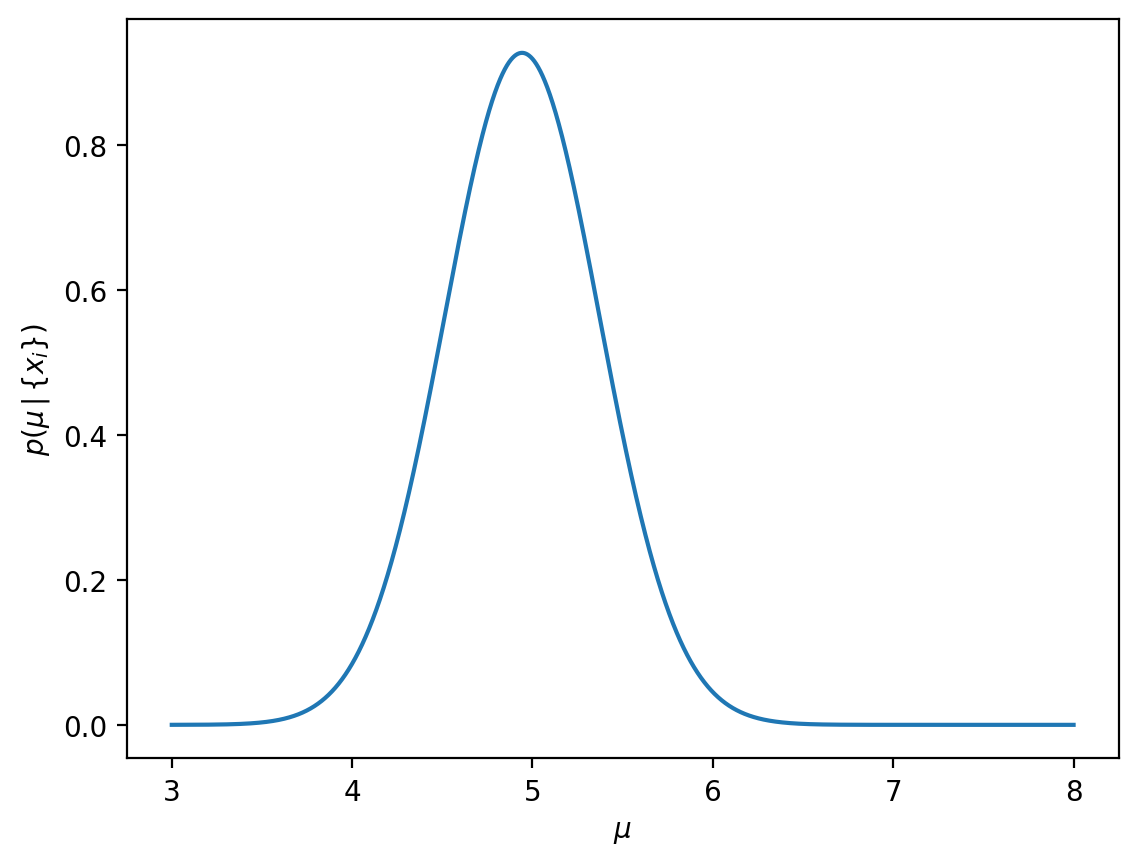

In [59]:
#5

upp = 5.4
low = 4.6
mu_prop = np.linspace(3,8, 10**4)
pos2 = npost(mu_prop, upp, low)

plt.plot(mu_prop, pos2)
plt.xlabel('$\mu$');
plt.ylabel('$p(\mu\,|\,\{x_i\})$');

cred_l, err_l = credible_int_left(npost, mu_grid, 0.683, upp, low, tol=0.01)
cred_r, err_r = credible_int_right(npost, mu_grid, 0.683, upp, low, tol=0.01)

print(f'New credible interval is: {cred_r - cred_l}')
print(r'New $\mu_{MAP}$ is', get_mu_MAP(npost, upp, low))

In [60]:
#6

def Gprior(mu, mean, stdv):
    return 1/(np.sqrt(2*np.pi) * stdv) * np.exp(-0.5 * ((mu - mean)/stdv)**2 ) 

def G_unpost(mu, mean, stdv):
    return L(mu) * Gprior(mu, mean, stdv)

def G_npost(mu, mean, stdv):
    unpos = G_unpost(mu, mean, stdv)

    nfac = integrate.quad(G_unpost, -np.inf, np.inf, args = (mean, stdv))[0]
    npos = unpost(mu, mean, stdv)/nfac
    return npos

mu_prop = np.linspace(0,10, 10**3)
Gpos = G_npost(mu_prop, 6, 0.3)


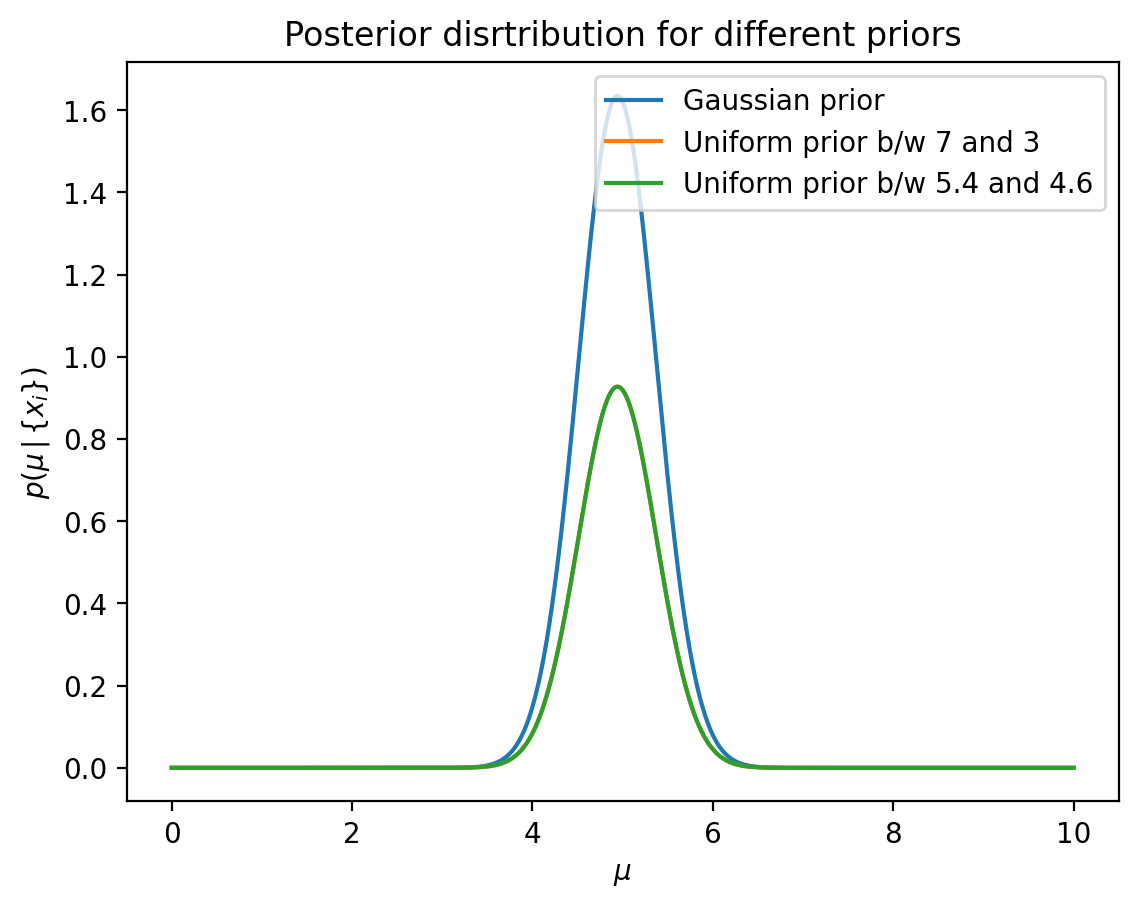

In [61]:
#7
plt.plot(mu_prop, Gpos, label='Gaussian prior')
plt.plot(mu_prop, npost(mu_prop, 7, 3), label = 'Uniform prior b/w 7 and 3')
plt.plot(mu_prop, npost(mu_prop, 5.4, 4.6), label = 'Uniform prior b/w 5.4 and 4.6')
plt.xlabel('$\mu$');
plt.ylabel('$p(\mu\,|\,\{x_i\})$');
plt.title('Posterior disrtribution for different priors')
plt.legend(loc='upper right')

In [62]:
#8

# def delta_prior(mu, mu0):
#     if mu == mu0:
#         return np.inf
#     else:
#         return 0

# def del_post(mu, mu0):
#     return L(mu) * delta_prior(mu, mu0)

# def evidence(mu):
#     res = integrate.quad(del_post, -np.inf, np.inf, args=mu2)[0]
#     return res

# evidence(mu_prop)

Analytically, we can compute the evidence as

\begin{align}
    p(D) &= \int L(D \,|\, \theta)\, p(\theta)\ d\theta\\
         &= \int L(D \,|\, \mu)\, \delta(\mu - \mu_0)\ d\theta\\
         &= L(D \,|\, \mu_0)\,
\end{align}

In [63]:
ev_u = integrate.quad(unpost, -np.inf, np.inf, args = (7, 3))[0]
ev_del = L(mu2)

print(f'evidence from delta prior: {ev_del}')
print(f'evidence from uniform prior: {ev_u}')

evidence from delta prior: 1.0725971325645043e-07
evidence from uniform prior: 2.8918831305401433e-08


In [64]:
#Bayes factor
bfac = ev_del/ev_u
print(bfac)

3.708991975634111


Since the Bayes' factor for the delta prior model is greater, it seems to be favoured over the uniform prior model. 

There should be an Occam penalty for the model with delta prior as it is enforces one value of the mean. Such a penalty has not been applied when comparing Bayes' factors in our case.